## Standard ML Classifiers

In [1]:
import os
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/home/alan/projects/venv-jupyter/lib/python3.7/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
from load_and_preprocess_data import TrainDataInfo
from training_utils import TrainingUtils
#from image_utilities import ImageUtilities

# I really only need these objects for the sampling probs and weights
all_train_info = TrainDataInfo('train_fixed_rotation', kfold_splits=5)
train_utils = TrainingUtils(all_train_info, (299, 299, 3), 16)
NUM_COUNTRIES = len(all_train_info.country_names)

In [3]:
WEIGHT_MAP = dict([ (i, all_train_info.weight_scalars[i]) for i in range(NUM_COUNTRIES)])
print('Class weights')
for i in range(NUM_COUNTRIES):
    print(i, f'{WEIGHT_MAP[i]:.2f}', all_train_info.country_names[i])

Class weights
0 2.00 Armenia
1 1.19 Australia
2 0.80 Germany
3 1.00 Hungary+Slovakia+Croatia
4 1.05 Indonesia-Bali
5 0.89 Japan
6 0.95 Malaysia+Indonesia
7 0.96 Portugal+Brazil
8 0.80 Russia
9 0.85 Spain
10 0.80 Thailand


In [4]:
def read_traintest_split(kfold_index, train_or_test):
    assert train_or_test in ['train', 'test']
    fn_feat = f'feature_extractions/xception_with_3_inner_layers__fold_{kfold_index}_{train_or_test}_features.npy'
    fn_lbls = f'feature_extractions/xception_with_3_inner_layers__fold_{kfold_index}_{train_or_test}_labels.npy'
    return np.load(fn_feat), np.load(fn_lbls)

train_feats, train_lbls = read_traintest_split(0, 'train')
test_feats, test_lbls = read_traintest_split(0, 'test')
print('Training shapes:', train_feats.shape, train_lbls.shape)
print('Testing shapes:', test_feats.shape, test_lbls.shape)
print('Sample feat values:', test_feats[0,:5])
print('All test label values:', test_lbls)

# We might want to try just subsets of features
feat_blocks_edges = []
feat_blocks_edges.append([0*728, 1*728])  # From xception block 3
feat_blocks_edges.append([1*728, 2*728])  # From xception block 5
feat_blocks_edges.append([2*728, 3*728])  # From xception block 8
feat_blocks_edges.append([3*728, 3*728+2048]) # Std xception output

def get_only_blocks(feats, blk_list):
    for blk in blk_list:
        assert blk in list(range(4))
        
    out = []
    for blk in blk_list:
        lo,hi = feat_blocks_edges[blk]
        out.append(feats[:, lo:hi])
        
    return np.concatenate(out, axis=1)

print('Feat mtrx with only some blocks:', get_only_blocks(train_feats, [0,1,2]).shape)

Training shapes: (3408, 4232) (3408,)
Testing shapes: (146, 4232) (146,)
Sample feat values: [-325.26935  668.3108  -471.81216 -397.0533    93.32923]
All test label values: [ 0  0  0  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4
  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6
  6  6  6  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9
  9  9  9  9  9 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10]
Feat mtrx with only some blocks: (3408, 2184)


In [5]:
def fit_and_eval_logistic_regression(train_feats, train_lbls, test_feats, test_lbls, weight_map=None, C_val=0.1):
    
    logreg = LogisticRegression(C=C_val, class_weight=weight_map)
    logreg.fit(train_feats, train_lbls)
    
    y_pred = logreg.predict(test_feats)
    y_true = test_lbls
    
    return logreg, y_true, y_pred

In [6]:
def fit_and_eval_naive_bayes(train_feats, train_lbls, test_feats, test_lbls, weight_map=None, uniform=False):
    if uniform:
        priors = np.ones(shape=(NUM_COUNTRIES,)) / float(NUM_COUNTRIES)
    else:
        priors = None
        
    print('Priors:', priors)
        
    sample_weights = [weight_map[lbl] for lbl in train_lbls] if weight_map else None
    
    gnb = GaussianNB(priors=priors)
    gnb.fit(train_feats, train_lbls, sample_weights)
    
    y_pred = gnb.predict(test_feats)
    y_true = test_lbls
    
    return gnb, y_true, y_pred

In [8]:
def fit_and_eval_knn(train_feats, train_lbls, test_feats, test_lbls, weighted_dist=True, weight_map=None):
    
    wgt_str = 'distance' if weighted_dist else 'uniform'
    knn = KNeighborsClassifier(n_neighbors=3, weights=wgt_str)
    knn.fit(train_feats, train_lbls)
    
    y_pred = knn.predict(test_feats)
    y_true = test_lbls
    
    return knn, y_true, y_pred

In [10]:
def run_kfold_crossval(fit_and_eval_func, weight_map=None, single_k=None, feat_blocks=None):
    models = []
    all_y_true = []
    all_y_pred = []
    
    krange = [single_k] if single_k else range(5)
    
    for k in krange:
        train_feats, train_lbls = read_traintest_split(k, 'train')
        test_feats, test_lbls = read_traintest_split(k, 'test')
        if feat_blocks:
            orig_n_feats = train_feats.shape[1]
            train_feats = get_only_blocks(train_feats, feat_blocks)
            test_feats = get_only_blocks(test_feats, feat_blocks)
            print(f'Reduced feature set from {orig_n_feats} -> {train_feats.shape[1]}')
        
        model, y_true, y_pred = fit_and_eval_func(train_feats, train_lbls, 
                                                  test_feats, test_lbls,
                                                  weight_map=weight_map)
        
        models.append(model)
        all_y_true.append(y_true)
        all_y_pred.append(y_pred)
        print(f'Finished kfold {k}')
        print(sklearn.metrics.classification_report(y_true, y_pred))
        
    all_trues = np.concatenate(all_y_true, axis=0)
    all_preds = np.concatenate(all_y_pred, axis=0)
    print(all_trues.shape, all_preds.shape)
    train_utils.print_classification_report(all_trues, all_preds)
    train_utils.display_heatmaps(all_trues, all_preds)
    return models, all_trues, all_preds

/home/alan/projects/venv-jupyter/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/alan/projects/venv-jupyter/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Finished kfold 0
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.60      0.43      0.50         7
           2       0.81      0.77      0.79        22
           3       0.29      0.40      0.33        10
           4       0.71      0.56      0.63         9
           5       0.83      0.77      0.80        13
           6       1.00      0.36      0.53        11
           7       0.67      0.36      0.47        11
           8       0.46      0.92      0.61        25
           9       0.57      0.29      0.38        14
          10       0.74      0.67      0.70        21

    accuracy                           0.61       146
   macro avg       0.70      0.53      0.57       146
weighted avg       0.67      0.61      0.60       146



/home/alan/projects/venv-jupyter/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/alan/projects/venv-jupyter/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Finished kfold 1
              precision    recall  f1-score   support

           0       0.33      0.50      0.40         2
           1       0.50      0.14      0.22         7
           2       0.83      0.45      0.59        22
           3       0.38      0.30      0.33        10
           4       0.38      0.67      0.48         9
           5       0.79      0.85      0.81        13
           6       0.80      0.36      0.50        11
           7       0.80      0.36      0.50        11
           8       0.41      0.68      0.52        25
           9       0.45      0.36      0.40        14
          10       0.61      0.81      0.69        21

    accuracy                           0.54       145
   macro avg       0.57      0.50      0.50       145
weighted avg       0.60      0.54      0.54       145



/home/alan/projects/venv-jupyter/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/alan/projects/venv-jupyter/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Finished kfold 2
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.36      0.57      0.44         7
           2       0.75      0.57      0.65        21
           3       0.25      0.20      0.22        10
           4       0.62      0.89      0.73         9
           5       1.00      0.75      0.86        12
           6       0.67      0.36      0.47        11
           7       0.44      0.36      0.40        11
           8       0.49      0.88      0.63        25
           9       0.33      0.29      0.31        14
          10       0.79      0.52      0.63        21

    accuracy                           0.56       143
   macro avg       0.52      0.49      0.49       143
weighted avg       0.59      0.56      0.55       143



/home/alan/projects/venv-jupyter/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/alan/projects/venv-jupyter/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/alan/projects/venv-jupyter/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Finished kfold 3
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.80      0.57      0.67         7
           2       0.62      0.38      0.47        21
           3       0.26      0.50      0.34        10
           4       0.62      0.56      0.59         9
           5       0.69      0.92      0.79        12
           6       0.80      0.36      0.50        11
           7       1.00      0.09      0.17        11
           8       0.47      0.76      0.58        25
           9       0.29      0.38      0.33        13
          10       0.71      0.57      0.63        21

    accuracy                           0.53       142
   macro avg       0.66      0.51      0.52       142
weighted avg       0.62      0.53      0.52       142



/home/alan/projects/venv-jupyter/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/alan/projects/venv-jupyter/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Finished kfold 4
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.36      0.57      0.44         7
           2       0.55      0.52      0.54        21
           3       0.33      0.22      0.27         9
           4       0.80      0.89      0.84         9
           5       0.86      1.00      0.92        12
           6       0.80      0.36      0.50        11
           7       0.25      0.20      0.22        10
           8       0.46      0.88      0.60        24
           9       1.00      0.31      0.47        13
          10       0.77      0.50      0.61        20

    accuracy                           0.57       138
   macro avg       0.65      0.54      0.55       138
weighted avg       0.63      0.57      0.56       138

(714,) (714,)
                          precision    recall  f1-score   support

                 Armenia       0.67      0.36      0.47        11
               Australi

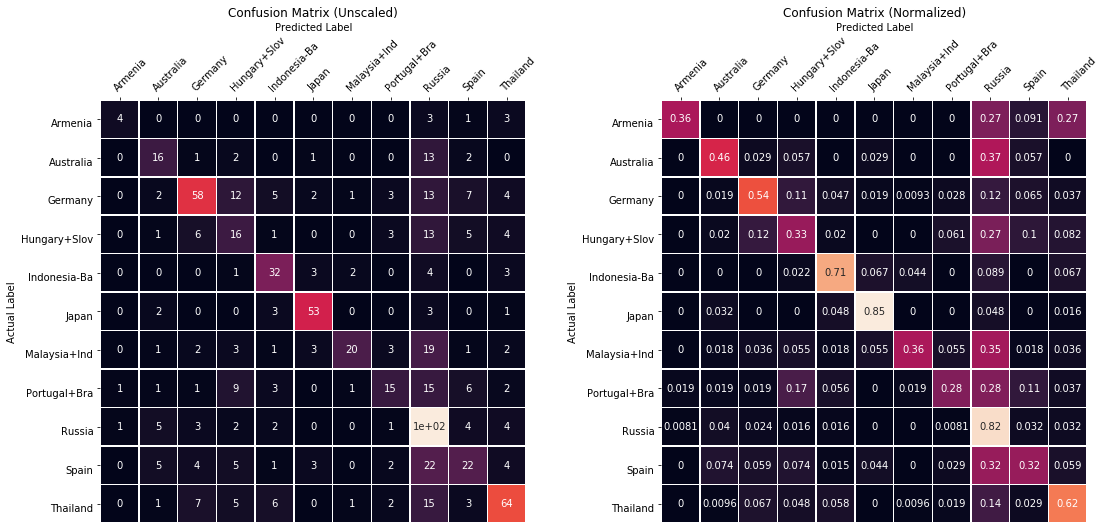

In [61]:
all_models, y_true, y_pred = run_kfold_crossval(fit_and_eval_logistic_regression)

Reduced feature set from 4232 -> 2184
Priors: None
Finished kfold 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.20      0.57      0.30         7
           2       0.00      0.00      0.00        22
           3       0.00      0.00      0.00        10
           4       0.11      0.22      0.14         9
           5       0.42      0.38      0.40        13
           6       0.00      0.00      0.00        11
           7       0.10      0.27      0.14        11
           8       1.00      0.08      0.15        25
           9       0.33      0.07      0.12        14
          10       0.15      0.24      0.18        21

    accuracy                           0.15       146
   macro avg       0.21      0.17      0.13       146
weighted avg       0.28      0.15      0.13       146

Reduced feature set from 4232 -> 2184
Priors: None
Finished kfold 1
              precision    recall  f1-score   suppo

/home/alan/projects/venv-jupyter/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/alan/projects/venv-jupyter/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Reduced feature set from 4232 -> 2184
Priors: None
Finished kfold 2
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.21      0.71      0.32         7
           2       0.12      0.05      0.07        21
           3       0.00      0.00      0.00        10
           4       0.12      0.22      0.16         9
           5       0.43      0.25      0.32        12
           6       0.00      0.00      0.00        11
           7       0.14      0.45      0.21        11
           8       0.25      0.04      0.07        25
           9       0.33      0.14      0.20        14
          10       0.00      0.00      0.00        21

    accuracy                           0.13       143
   macro avg       0.15      0.17      0.12       143
weighted avg       0.16      0.13      0.11       143

Reduced feature set from 4232 -> 2184
Priors: None
Finished kfold 3
              precision    recall  f1-score   suppo

/home/alan/projects/venv-jupyter/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/alan/projects/venv-jupyter/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Reduced feature set from 4232 -> 2184
Priors: None
Finished kfold 4
              precision    recall  f1-score   support

           0       0.06      0.50      0.11         2
           1       0.09      0.29      0.13         7
           2       1.00      0.10      0.17        21
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00         9
           5       0.25      0.25      0.25        12
           6       0.00      0.00      0.00        11
           7       0.13      0.40      0.20        10
           8       0.46      0.25      0.32        24
           9       0.22      0.15      0.18        13
          10       0.42      0.25      0.31        20

    accuracy                           0.18       138
   macro avg       0.24      0.20      0.15       138
weighted avg       0.35      0.18      0.19       138

(714,) (714,)
                          precision    recall  f1-score   support

                 Armenia       0.02   

/home/alan/projects/venv-jupyter/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


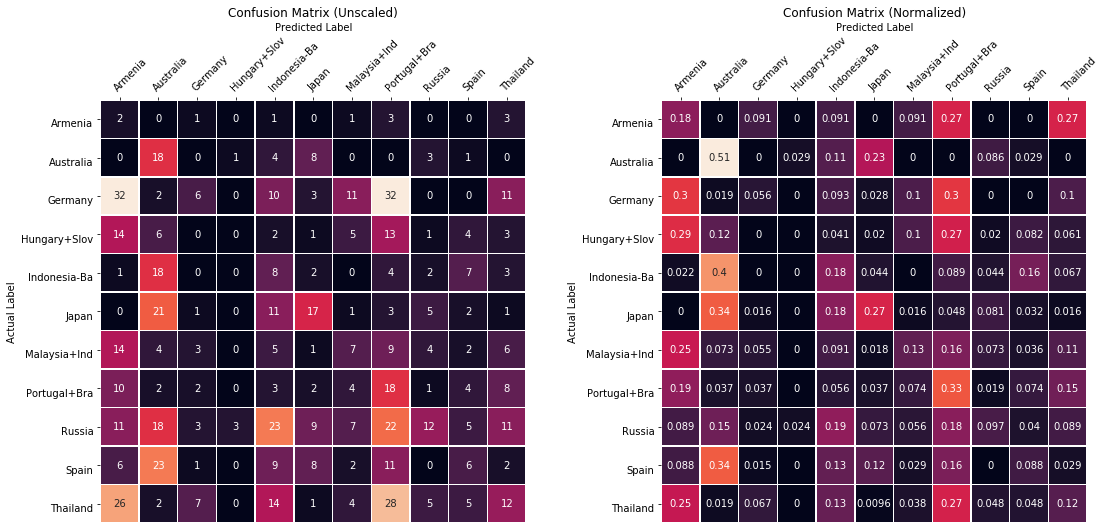

In [67]:
all_models, y_true, y_pred = run_kfold_crossval(fit_and_eval_naive_bayes, feat_blocks=[0,1,2], weight_map=WEIGHT_MAP)

Reduced feature set from 4232 -> 2184
Finished kfold 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.22      0.29      0.25         7
           2       0.50      0.32      0.39        22
           3       0.11      0.10      0.11        10
           4       0.20      0.44      0.28         9
           5       0.36      0.31      0.33        13
           6       0.27      0.36      0.31        11
           7       0.33      0.45      0.38        11
           8       0.48      0.44      0.46        25
           9       0.22      0.14      0.17        14
          10       0.25      0.24      0.24        21

    accuracy                           0.31       146
   macro avg       0.27      0.28      0.27       146
weighted avg       0.32      0.31      0.31       146

Reduced feature set from 4232 -> 2184
Finished kfold 1
              precision    recall  f1-score   support

           0       0.3

/home/alan/projects/venv-jupyter/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


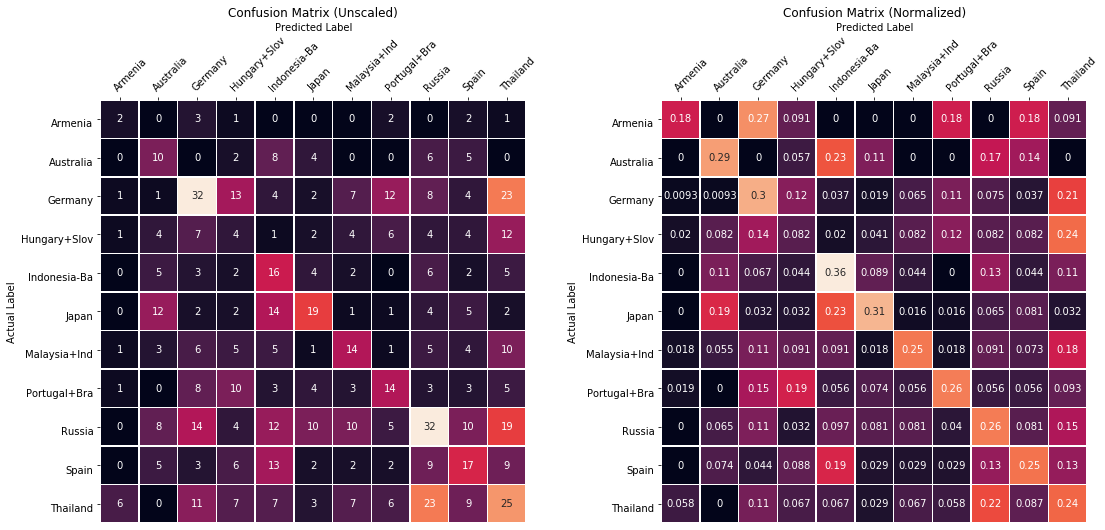

In [13]:
all_models, y_true, y_pred = run_kfold_crossval(fit_and_eval_knn, feat_blocks=[0,1,2]) #feat_blocks=[0,1,2], weight_map=WEIGHT_MAP)